## Group 19
### HA2 - Mining frequent itemsets

Cátia Antunes (60494) - 15h<br>Donato Aveiro (46269) - 15h<br>Márcia Vital (59488) - 15h<br>Sean Gorman (59492) - 15h

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules, fpmax
from mlxtend.preprocessing import TransactionEncoder
from PD_freqitems import freqitemsets
from pyfim import pyeclat
import ast
import itertools

### Data preprocessing

In [2]:
#Read product names and IDs
lines=open("products.txt", "rt", encoding="utf8").readlines()
prod_dict={}
products=[0]*len(lines)
for lin in lines[1:]:
    pid, pname, aid, did=lin.strip().split("\t")    
    products[int(pid)]=pname
    prod_dict[pid] = pname

del products[0] #the products list contains a 0 as the first element
#products

#Read transactions
orders=pickle.load(open("order_products.pickle", "rb"))

#Convert the transaction data into a list of lists
orders_list = [list(order) for order in orders.values()]
#orders_list

#Encode the transaction data as a binary matrix
te = TransactionEncoder()
te_ary = te.fit_transform(orders_list, sparse=True)

df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
#df

df.columns = [prod_dict[str(key)] for key in df.columns]
#df

### Objective 1 - Analyze the itemset/rules generation procedure

In [23]:
D={"threshold": [0.2, 0.1, 0.05, 0.02, 0.01], 
   "num_itemsets":[],
   "apriori":[], 
   "FP-growth":[], 
   "ECLAT":[], 
   "PD":[]}

for min_supp in D["threshold"]:
    t0 = time.time()
    FI_apriori=apriori(df, min_supp)
    t1 = time.time()
    D["num_itemsets"].append(FI_apriori.shape[0])
    D["apriori"].append(t1-t0)

    FI_fpg= fpgrowth(df, min_supp)
    t2 = time.time()
    D["FP-growth"].append(t2-t1)

    FI_eclat= pyeclat(orders_list, min_supp)    
    t3 = time.time()
    D["ECLAT"].append(t3-t2)

    FI_pdfis= freqitemsets(orders_list, min_supp)    
    t4 = time.time()
    D["PD"].append(t4-t3)

    
    print(min_supp, FI_apriori.shape[0],"\n\tApriori time:", t1-t0, 
          "\n\tFP-growth time:",t2-t1,
          "\n\tECLAT time:", t3-t2,
          "\n\tPD time:", t4-t3)
    

df_performance=pd.DataFrame(D)
df_performance

0.2 0 
	Apriori time: 2.4536550045013428 
	FP-growth time: 8.479583024978638 
	ECLAT time: 47.46721792221069 
	PD time: 24.47307014465332
0.1 2 
	Apriori time: 1.4667608737945557 
	FP-growth time: 9.020726919174194 
	ECLAT time: 424.0796871185303 
	PD time: 32.51881217956543
0.05 6 
	Apriori time: 1.7837262153625488 
	FP-growth time: 9.900385856628418 
	ECLAT time: 59.272298097610474 
	PD time: 33.426018714904785
0.02 39 
	Apriori time: 17.672621965408325 
	FP-growth time: 13.631991863250732 
	ECLAT time: 74.09733724594116 
	PD time: 28.20151400566101


: 

: 

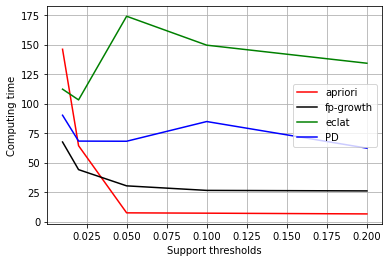

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(df_performance["threshold"], df_performance["apriori"], c='r', label='apriori')
plt.plot(df_performance["threshold"], df_performance["FP-growth"], c='k', label='fp-growth')
plt.plot(df_performance["threshold"], df_performance["ECLAT"], c='g', label='eclat')
plt.plot(df_performance["threshold"], df_performance["PD"], c='b', label='PD')
plt.xlabel("Support thresholds")
plt.ylabel("Computing time")
plt.grid()
plt.legend()
plt.invert_xaxis()
plt.show()

Although the apriori algorithm has the best performance for higher support thresholds, it is quickly outperformed by all the other algorithms for lower support thresholds. 

ECLAT is clearly the worst algorithm in general, which is surprising, since it supposedly scales well for large datasets.

FP-growth is the best-performing algorithm for lower support thresholds. Thus, from now on we will be using FP-growth.

The function below will allow us to find the minimum support for our chosen algorithm. The aim is to lower the minimum support in increments, all the while saving the relevant information and exporting a frequnt_itemset csv file. This way, even if the kernel crashes the most recent data will still be saved. 

In [ ]:
#Here is the main search for the minimum support

def find_min_support():
    min_support = 0.0
    increment = 0.0
    max_time = 60*60*2 # 2 hours in seconds
    starting_support = [0.1, 0.01, 0.001, 0.0001, 0.00001]
    cont = True
    with open("min_support3.txt", "w") as f:
        for i in range(len(starting_support)):
            if round(min_support, 6) == 0.0:
                min_support = starting_support[i]
                increment = starting_support[i]/10
                cont = True
            else:
                continue
            while cont == True:
                start_time = time.time()
                frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
                #Save the frequent itemsets to a csv file
                frequent_itemsets.to_csv('frequent_itemsets4.csv', index=False)
                end_time = time.time()
                memory_usage = frequent_itemsets.memory_usage(deep=True).sum()
                #total_memory = psutil.virtual_memory().available
                elapsed_time = end_time - start_time

                #Record the results and save to file
                f.write('Minimum support: {:.3f}, Time: {:.3f} s, FI Mem usage: {:.3f}MB\n'.format(round(min_support, 6), elapsed_time, memory_usage/1024/1024))
                f.write(f"{round(min_support, 6)}\n")
                print('Minimum support: {:.3f}, Time: {:.3f} s, FI Mem usage: {:.3f}MB'.format(round(min_support, 6), elapsed_time, memory_usage/1024/1024))
                
                min_support -= increment
                if round(min_support, 6) == 0.0:
                    cont = False
                
                print(f"Continue: {cont}")
                if elapsed_time > max_time:
                    print(f"Minimum support: {round(min_support, 6)} exceeded time limit")
                    break

#find_min_support()

In [18]:
with open("min_support3.txt", "r") as f:    
    #Store the lines in a list
    lines = f.readlines()
    #Get the last line without \n
    min_sup = float(lines[-1].rstrip())
    print(f"Minimum support: {min_sup}")
    
    min_sups = [float(lines[i].split()[2].replace(',', '')) for i in range(0, len(lines), 2)]

    times = [float(lines[i].split()[4].replace(',', '')) for i in range(0, len(lines), 2)]

    mem_usage = [float(lines[i].split()[9].replace('MB', '')) for i in range(0, len(lines), 2)]

Minimum support: 0.0005


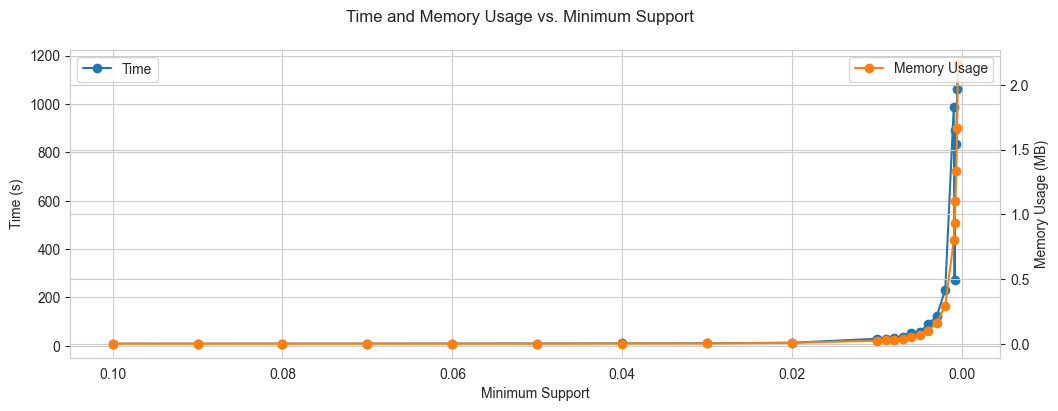

In [22]:
#Create a new figure
fig, ax1 = plt.subplots()
fig.set_size_inches(12, 4)

#Add the time data to the first y-axis
ax1.plot(min_sups, times, label='Time', color='tab:blue', marker='o')
ax1.set_xlabel('Minimum Support')
ax1.set_ylabel('Time (s)')

#Create a second y-axis and add the memory usage data
ax2 = ax1.twinx()
ax2.plot(min_sups, mem_usage, label='Memory Usage', color='tab:orange', marker='o')
ax2.set_ylabel('Memory Usage (MB)')

#Set the layout for the figure
fig.suptitle('Time and Memory Usage vs. Minimum Support')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
sns.set_style('whitegrid')

#Reverse the x-axis
ax1.invert_xaxis()
plt.show()

In [9]:
fi = pd.read_csv('frequent_itemsets4.csv')

#Convert itemsets from strings to back to frozenset
for i in range(0, len(fi["itemsets"])):
    # Remove the 'frozenset()' part from the string
    line = fi["itemsets"][i].replace("frozenset(", "").replace(')', '')
    # Convert the remaining string to a frozenset using ast.literal_eval
    fi["itemsets"][i] = frozenset(ast.literal_eval(line))

/var/folders/hw/n2l_r7sj3fj2mg88w0q6fpcc0000gn/T/ipykernel_88622/1031228175.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi["itemsets"][i] = frozenset(ast.literal_eval(line))


In [15]:
fi['length'] = fi['itemsets'].apply(lambda x: len(x))
fi.sort_values(by=['length'], inplace=True)
fi.reset_index(drop=True, inplace=True)
fi

,support,itemsets,length
0,0.022625,(Carrots),1
1,0.006034,(Organic Egg Whites),1
2,0.001959,(Garlic Powder),1
3,0.000754,(All Natural No Stir Creamy Almond Butter),1
4,0.075251,(Organic Baby Spinach),1
...,...,...,...
10502,0.001042,"(Organic Baby Spinach, Organic Hass Avocado, O...",4
10503,0.000624,"(Organic Cucumber, Organic Hass Avocado, Organ...",4
10504,0.000618,"(Organic Baby Spinach, Banana, Organic Avocado...",4
10505,0.000561,"(Organic Hass Avocado, Organic Yellow Onion, O...",4


### Objective 2 - Identify the most relevant rules


In [39]:
all_rules = association_rules(fi, metric="support", min_threshold=0.0005)
all_rules = all_rules[all_rules['lift'] > 3]
all_rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
32,(Cucumber Kirby),(Large Lemon),0.030270,0.047485,0.004497,0.148559,3.128568,0.003060,1.118710
33,(Large Lemon),(Cucumber Kirby),0.047485,0.030270,0.004497,0.094703,3.128568,0.003060,1.071172
36,(Strawberries),(Medium Scarlet Raspberries),0.044466,0.001567,0.000629,0.014145,9.027884,0.000559,1.012758
37,(Medium Scarlet Raspberries),(Strawberries),0.001567,0.044466,0.000629,0.401429,9.027884,0.000559,1.596361
40,(Mango Chunks),(Organic Whole Strawberries),0.005505,0.009781,0.000632,0.114752,11.732040,0.000578,1.118578
41,(Organic Whole Strawberries),(Mango Chunks),0.009781,0.005505,0.000632,0.064589,11.732040,0.000578,1.063163
82,(Synergy Organic Kombucha Gingerberry),(Organic Raw Kombucha Gingerade),0.002771,0.006441,0.000629,0.226824,35.215624,0.000611,1.285036
83,(Organic Raw Kombucha Gingerade),(Synergy Organic Kombucha Gingerberry),0.006441,0.002771,0.000629,0.097600,35.215624,0.000611,1.105085
128,(Synergy Organic Kombucha Gingerberry),(Trilogy Kombucha Drink),0.002771,0.005223,0.000751,0.271044,51.895156,0.000737,1.364660
129,(Trilogy Kombucha Drink),(Synergy Organic Kombucha Gingerberry),0.005223,0.002771,0.000751,0.143827,51.895156,0.000737,1.164751


With a large number of frequent itemsets, we're able to generate a large number of rules. This is evident by the tight restriction we have in place with the above set of rules. Even with filtering for a lift above 3, we still get over 6,500 results. This shows the need to generate closed and specifically maximal itemsets, to really narrow down our search for the most relevant rules and information.

The conviction values do not seem to change much from rule to rule, with the majority having a value less than 1.2 and all having a value greater than 1, which indicates that the presence of the antecedent has a positive effect on the occurence of the consequent for all rules. As such, we will not focus too much on this metric. Likewise, as defined in Objective 1, the support values are all predfined, which means that this metric will not be as appropriate to compare rules as lift and confidence.

There seems to be a greater range of values for the lift metric and to a lesser extent the confidence. 

In [40]:
all_rules.sort_values(by=['confidence'], ascending=False, inplace=True)
all_rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
19578,"(Peach Pear Flavored Sparkling Water, Lime Spa...",(Sparkling Water Grapefruit),0.001312,0.023605,0.000850,0.648174,27.459601,0.000819,2.775226
19650,"(Peach Pear Flavored Sparkling Water, Sparklin...",(Sparkling Water Grapefruit),0.001019,0.023605,0.000649,0.636253,26.954539,0.000624,2.684268
13716,"(Sparkling Water Berry, Lime Sparkling Water)",(Sparkling Water Grapefruit),0.001308,0.023605,0.000827,0.632105,26.778810,0.000796,2.654003
14078,(Total 2% All Natural Greek Strained Yogurt wi...,(Total 2% with Strawberry Lowfat Greek Straine...,0.001218,0.009298,0.000748,0.614147,66.049092,0.000737,2.567563
13614,"(Sparkling Water Berry, Sparkling Lemon Water)",(Sparkling Water Grapefruit),0.001174,0.023605,0.000711,0.605988,25.672405,0.000684,2.478087
17311,(Total 2% Lowfat Greek Strained Yogurt with Pe...,(Total 2% with Strawberry Lowfat Greek Straine...,0.001156,0.009298,0.000700,0.605327,65.100513,0.000689,2.510183
16608,"(Non Fat Acai & Mixed Berries Yogurt, Non Fat ...",(Icelandic Style Skyr Blueberry Non-fat Yogurt),0.000978,0.005990,0.000588,0.600954,100.326689,0.000582,2.490965
17324,(Total 2% Lowfat Greek Strained Yogurt with Pe...,(Total 2% with Strawberry Lowfat Greek Straine...,0.001954,0.009298,0.001161,0.594238,63.907895,0.001143,2.441580
13782,"(Pure Sparkling Water, Lime Sparkling Water)",(Sparkling Water Grapefruit),0.001245,0.023605,0.000734,0.589660,24.980678,0.000705,2.379481
14070,"(Pure Sparkling Water, Sparkling Lemon Water)",(Sparkling Water Grapefruit),0.001221,0.023605,0.000714,0.584968,24.781895,0.000685,2.352579


All the rules in our set have a confidence above 58%. This means that, for every rule, more than 58% of the transactions that contain the antecedent also contain the consequent, which seems to make sense looking at the items and imagining them being purchased in a real world scenario.

The lift values are all great, ranging from ~ 25 to 100. This tells us that the probability of the consequent being purchased when the antecedent is also purchased is much greater than the probability of the consequent being purchased in general. This hints at a non-random relationship between these products.

Now, let's identify the maximal and closed itemsets for the same level of support considered.

In [27]:
#Find closed itemsets

frequent = fi
su = frequent.support.unique() #all unique support count

#Dictionary storing itemsets with the same support count key
fredic = {}
for i in range(len(su)):
    inset = list(frequent.loc[frequent.support ==su[i]]['itemsets'])
    fredic[su[i]] = inset

#Dictionary storing itemsets with support count <= key
fredic2 = {}
for i in range(len(su)):
    inset2 = list(frequent.loc[frequent.support<=su[i]]['itemsets'])
    fredic2[su[i]] = inset2

#Find closed frequent itemsets with length >= 2
closed_itemsets = []
for index, row in frequent.iterrows():
    isclose = True
    cli = row['itemsets']
    cls = row['support']
    checkset = fredic[cls]
    
    #Only include closed frequent itemsets with length >= 2
    if len(cli) < 2:
        continue
    
    for i in checkset:
        if (cli!=i):
            if(frozenset.issubset(cli,i)):
                isclose = False
                break
    
    if(isclose):
        closed_itemsets.append({'support': cls, 'itemsets': cli})

#Create dataframe with closed frequent itemsets and length column
closed_itemsets_df = pd.DataFrame(closed_itemsets)
closed_itemsets_df['length'] = closed_itemsets_df['itemsets'].apply(lambda x: len(x))
closed_itemsets_df

,support,itemsets,length
0,0.001880,"(Organic Raspberries, Seedless Red Grapes)",2
1,0.003125,"(Strawberries, Seedless Red Grapes)",2
2,0.001156,"(Organic Garlic, Seedless Red Grapes)",2
3,0.000665,"(Roasted & Salted Almonds, Banana)",2
4,0.003021,"(Cucumber Kirby, Bag of Organic Bananas)",2
...,...,...,...
7100,0.001042,"(Organic Baby Spinach, Organic Hass Avocado, O...",4
7101,0.000624,"(Organic Cucumber, Organic Hass Avocado, Organ...",4
7102,0.000618,"(Organic Baby Spinach, Banana, Organic Avocado...",4
7103,0.000561,"(Organic Hass Avocado, Organic Yellow Onion, O...",4


In [29]:
#Find maximal frequent itemsets

min_len = 2
ml = []
for index, row in frequent.iterrows():
    isclose = True
    cli = row['itemsets']
    if len(cli) < min_len:
        continue
    cls = row['support']
    checkset = fredic2[cls]
    for i in checkset:
        if (cli!=i):
            if(frozenset.issubset(cli,i)):
                isclose = False
                break
    
    if(isclose):
        ml.append([cls, cli])

ml_df = pd.DataFrame(ml, columns=['support', 'itemsets'])
ml_df['length'] = ml_df['itemsets'].apply(lambda x: len(x))
ml_df

,support,itemsets,length
0,0.001156,"(Organic Garlic, Seedless Red Grapes)",2
1,0.000665,"(Roasted & Salted Almonds, Banana)",2
2,0.000544,"(Organic Half & Half, Uncured Genoa Salami)",2
3,0.001244,"(Organic Blueberries, Seedless Red Grapes)",2
4,0.000843,"(Mango Chunks, Bag of Organic Bananas)",2
...,...,...,...
6208,0.001042,"(Organic Baby Spinach, Organic Hass Avocado, O...",4
6209,0.000624,"(Organic Cucumber, Organic Hass Avocado, Organ...",4
6210,0.000618,"(Organic Baby Spinach, Banana, Organic Avocado...",4
6211,0.000561,"(Organic Hass Avocado, Organic Yellow Onion, O...",4


The maximal and closed itemsets are similar but different, as to be expected. Let's generate rules for the maximal itemsets, with some additional confidence and lift constraints.

In [36]:
#Maximal

cons_supports = []
maximal_itemsets = fi.copy()
for i, itemset in fi.iterrows():
    if not any(fi['itemsets'].apply(lambda x: x.issuperset(itemset['itemsets']) and x != itemset['itemsets'])):
        continue
    maximal_itemsets = maximal_itemsets.drop(i)

maximal_rules = []
for i, itemset in maximal_itemsets.iterrows():
    itemset_support = itemset['support']
    cons_supports.append(itemset_support)
    itemset_items = itemset['itemsets']
    itemset_size = len(itemset_items)
    
    #Generate all possible subsets of the itemset
    subsets = [frozenset(x) for x in set(itertools.combinations(itemset_items, itemset_size-1))]
    
    #Generate association rules for each subset
    if len(subsets) > 1:
        for subset in subsets:
            antecedent_support = fi.loc[fi['itemsets']==subset, 'support'].values[0] #
            consequent_support = itemset_support
            rule_support = itemset_support
            confidence = rule_support / antecedent_support
            lift = itemset_support / (antecedent_support * consequent_support)
            
            #Add rule to the list if it meets the confidence and lift thresholds
            if confidence >= 0.2 and lift >= 1:
                maximal_rules.append({'antecedent': subset, 'consequent': itemset_items-subset, 'support': rule_support, 'confidence': confidence, 'lift': lift})

max_rules = pd.DataFrame(maximal_rules, columns=['antecedent', 'consequent', 'support', 'confidence', 'lift'])
max_rules

,antecedent,consequent,support,confidence,lift
0,(Roasted & Salted Almonds),(Banana),0.000665,0.256140,385.153229
1,(Medium Scarlet Raspberries),(Strawberries),0.000629,0.401429,638.251737
2,(Synergy Organic Kombucha Gingerberry),(Organic Raw Kombucha Gingerade),0.000629,0.226824,360.816386
3,(Organic Mixed Vegetables),(Bag of Organic Bananas),0.000745,0.242381,325.490939
4,(Synergy Organic Kombucha Gingerberry),(Trilogy Kombucha Drink),0.000751,0.271044,360.816386
...,...,...,...,...,...
2454,"(Organic Hass Avocado, Organic Yellow Onion, O...",(Bag of Organic Bananas),0.000561,0.419145,746.950279
2455,"(Organic Hass Avocado, Organic Yellow Onion, B...",(Organic Strawberries),0.000561,0.254874,454.206556
2456,"(Organic Hass Avocado, Bag of Organic Bananas,...",(Organic Strawberries),0.000510,0.268481,526.942141
2457,"(Bag of Organic Bananas, Organic Strawberries,...",(Organic Hass Avocado),0.000510,0.323843,635.601819


In [38]:
max_rules.sort_values(by=['confidence'], ascending=False, inplace=True)
max_rules.head(10)

,antecedent,consequent,support,confidence,lift
2362,"(Peach Pear Flavored Sparkling Water, Lime Spa...",(Sparkling Water Grapefruit),0.000850,0.648174,762.179706
2378,"(Peach Pear Flavored Sparkling Water, Sparklin...",(Sparkling Water Grapefruit),0.000649,0.636253,981.041807
1208,"(Sparkling Water Berry, Lime Sparkling Water)",(Sparkling Water Grapefruit),0.000827,0.632105,764.536029
1284,(Total 2% All Natural Greek Strained Yogurt wi...,(Total 2% with Strawberry Lowfat Greek Straine...,0.000748,0.614147,820.958631
1190,"(Sparkling Water Berry, Sparkling Lemon Water)",(Sparkling Water Grapefruit),0.000711,0.605988,851.847907
1915,(Total 2% Lowfat Greek Strained Yogurt with Pe...,(Total 2% with Strawberry Lowfat Greek Straine...,0.000700,0.605327,864.910950
1753,"(Non Fat Acai & Mixed Berries Yogurt, Non Fat ...",(Icelandic Style Skyr Blueberry Non-fat Yogurt),0.000588,0.600954,1022.217488
1920,(Total 2% Lowfat Greek Strained Yogurt with Pe...,(Total 2% with Strawberry Lowfat Greek Straine...,0.001161,0.594238,511.759631
1221,"(Pure Sparkling Water, Lime Sparkling Water)",(Sparkling Water Grapefruit),0.000734,0.589660,802.915584
1280,"(Pure Sparkling Water, Sparkling Lemon Water)",(Sparkling Water Grapefruit),0.000714,0.584968,819.076178


Here we see some of the most relevant rules. Different types of yogurts and sparkling water beverages tend to be bought together.